In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision.io import read_image
import torchvision.transforms as transforms

import os
import cv2
import warnings
import numpy as np
import pandas as pd
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm

from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.exceptions import UndefinedMetricWarning

In [43]:
!pip install openvino-dev[pytorch,onnx]

# Model

In [44]:
class ConvBnRelu(nn.Module):
    """Convenience layer combining a Conv2d, BatchNorm2d, and a ReLU activation.

    Original source of this code comes from
    https://github.com/lingtengqiu/Deeperlab-pytorch/blob/master/seg_opr/seg_oprs.py
    """
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0,
                 norm_layer=nn.BatchNorm2d):
        super(ConvBnRelu, self).__init__()
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size,
                              stride=stride, padding=padding, bias=False)
        self.bn = norm_layer(out_planes, eps=1e-5)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

In [45]:
class ConvRelu(nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(ConvRelu, self).__init__(
            nn.Conv2d(in_channels, out_channels, kernel_size, padding=1),
            nn.ReLU(inplace=True))

In [46]:
class MobileNetV3_Modified(nn.Module):
    def __init__(self):
        super(MobileNetV3_Modified, self).__init__()
        mobile_net_v3_small = torchvision.models.mobilenet_v3_small(weights='DEFAULT')
        
        # Extract only features layer
        self.blocks = nn.ModuleList()
        self.num_layers = len(mobile_net_v3_small.features) 
        for i in range(self.num_layers):
            if (i == 4):
                mobile_net_v3_small.features[i].block[1][0].stride = (1, 1)
            #elif (i == 9 or i == 11):
            #    mobile_net_v3_small.features[i].block[1][0].padding = (4, 4)
            #    mobile_net_v3_small.features[i].block[1][0].dilation = 2
            #elif (i == 10):
            #    mobile_net_v3_small.features[i].block[1][0].padding = (8, 8)
            #    mobile_net_v3_small.features[i].block[1][0].dilation = 4 
            self.blocks.append(mobile_net_v3_small.features[i])
            
    def forward(self, x):
        outputs = []
        for i in range(self.num_layers):
            x = self.blocks[i](x)
            if (i == 0 or i == 8 or i == self.num_layers-1):
                outputs.append(x)
        return outputs

In [47]:
class SegHead(nn.Module):
    def __init__(self, d_model=128, n_classes=2):
        super(SegHead, self).__init__()
        self.reduce_conv = ConvRelu(576, d_model, 1)
        self.up_conv1 = ConvRelu(48 + d_model, d_model, 1)
        self.up_conv2 = nn.Conv2d(16 + d_model, n_classes, 1)
            
    def forward(self, x1, x2, x3, x_shape):        
        x3 = self.reduce_conv(x3)
        x3 = F.interpolate(x3, x2.shape[2:], mode='bilinear', align_corners=True)
                
        x2 = torch.cat([x2, x3], dim=1)
        x2 = self.up_conv1(x2)
        x2 = F.interpolate(x2, x1.shape[2:], mode='bilinear', align_corners=True)
        
        x1 = torch.cat([x1, x2], dim=1)
        x1 = self.up_conv2(x1)
        output = F.interpolate(x1, x_shape[2:], mode='bilinear', align_corners=True)
        #output = torch.sigmoid(output)
        
        return output

In [48]:
class Multitask_MobileV3Smal_LRASPP(nn.Module):
    def __init__(self, backbone,lung_head,infected_head, num_class_classify=3):
        super(Multitask_MobileV3Smal_LRASPP, self).__init__()
        self.backbone = backbone()
        self.lung_head = lung_head()
        self.infected_head = infected_head()
        self.classify_branch =  nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size=1),
            nn.Flatten(),
            nn.Linear(576, 1024),
            nn.Hardswish(),
            nn.Linear(in_features=1024, out_features=num_class_classify, bias=True))
        
    def forward(self, x):
        x_shape = x.shape
        x1, x2, x3 = self.backbone(x)
        lung_output= self.lung_head(x1, x2, x3, x_shape)
        infect_output  = self.infected_head(x1, x2, x3, x_shape)
        y = self.classify_branch(x3)
        return y, lung_output, infect_output        

# Dataloader

In [49]:


root = '/kaggle/input/covidqu/Infection Segmentation Data/Infection Segmentation Data/Test'
temp = os.listdir(root)
for i in temp:
    print(len(os.listdir(os.path.join(root, i + '/images'))))


292
291
583


In [50]:
#data loader r
import numpy as np
import imgaug.augmenters as iaa
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
import pandas as pd
from torchvision.io import read_image
import cv2
import torch.nn.functional as F
class Covid(Dataset):
    def __init__(self, rootpath, cropsize=(256, 256), mode='train', *args, **kwargs):
        super(Covid, self).__init__(*args, **kwargs)
        assert mode in ('train', 'val', 'test')
        self.mode = mode
        self.cropsize=cropsize

        self.rootpth = rootpath
        self.imgs = []

        class_dir = os.listdir(os.path.join(self.rootpth,self.mode.capitalize()))  # class
        self.class_cvt = { 'Normal':0, 'COVID-19':1,'Non-COVID':2}
    
        # print(class_dir)
        for _class in class_dir:
            self.class_path = os.path.join(self.rootpth,self.mode.capitalize())
            self.img_path = os.path.join(self.class_path,_class,'images')
#             print(self.img_path)
            img_lst = os.listdir(self.img_path)
#             print(img_lst)
#             infect_imgs = os.listdir(self.img_path.replace('Lung Segmentation Data','Infection Segmentation Data',2))
            img_lst.sort()
            for img in img_lst:
                self.imgs.append((img,self.class_cvt[_class]))
#         print(self.imgs)


#         #  pre-processing
        self.to_tensor = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            ])
        self.trans_color = iaa.Sequential([
          iaa.LinearContrast((0.4, 1.6)),
#           iaa.AddToHueAndSaturation((-50, 50), per_channel=True),
#           iaa.Add((-40, 40), per_channel=0.5, name="color-jitter")
        ])
        self.trans_train = iaa.Sequential([
#           iaa.Resize(self.cropsize),
          iaa.Fliplr(0.5),
#           iaa.Affine(rotate=(-45, 45),
#                     translate_percent={"x": (-0.02, 0.02), "y": (-0.02, 0.02)}),
      ])

    def __getitem__(self, idx):
        impth = self.imgs[idx]
#         print(impth)
        self.img_path = os.path.join(self.class_path,list(self.class_cvt.keys())[impth[1]],'images')
        img =  cv2.imread(os.path.join(self.img_path,impth[0]))
        img = cv2.resize(img,self.cropsize, cv2.INTER_LINEAR)
        
#         label = torch.tensor(impth[1])
        label = F.one_hot(torch.tensor(impth[1]), num_classes=3)
#         print(label)

        mask_path = self.img_path.replace('images','lung masks')
        
        lung_mask = cv2.imread(os.path.join(mask_path,impth[0]),0)
        lung_mask = cv2.resize(lung_mask,self.cropsize, cv2.INTER_NEAREST ).astype(np.int64)
#         lung_mask = np.where(lung_mask==0, 0 , 1)
        
        infect_path = self.img_path.replace('images','infection masks')
        infect_mask = cv2.imread(os.path.join(infect_path,impth[0]),0)
        infect_mask = cv2.resize(infect_mask,self.cropsize, cv2.INTER_NEAREST ).astype(np.int64)
#         infect_mask = np.where(infect==0, 0 , 1)

        #if self.mode == 'test':
            #return img, label,lung_mask, infect_mask
            
            
        
        if self.mode == 'train':
#             color = self.trans_color.to_deterministic()

#             img = color.augment_image(img)
            det_tf = self.trans_train.to_deterministic()
            img = det_tf.augment_image(img)
            lung_mask = det_tf.augment_image( lung_mask)
            infect_mask = det_tf.augment_image(infect_mask)


        img = self.to_tensor(img)
#         img = img.permute(2, 0, 1)
        
        lung_mask = np.where(lung_mask !=0,1.,0.)
        lung_mask = torch.from_numpy(lung_mask.astype(np.float32)).clone()
        lung_mask = F.one_hot(lung_mask.long(), num_classes=2)
        lung_mask = lung_mask.to(torch.float32)
        lung_mask = lung_mask.permute(2, 0, 1)
        
        infect_mask = np.where(infect_mask !=0,1.,0.)
        infect_mask = torch.from_numpy(infect_mask.astype(np.float32)).clone()
        infect_mask = F.one_hot(infect_mask.long(), num_classes=2)
        infect_mask = infect_mask.to(torch.float32)
        infect_mask = infect_mask.permute(2, 0, 1)
        

        return img, label, lung_mask, infect_mask



    def __len__(self):
        return len(self.imgs)

# Trainning

In [51]:
import gc
torch.cuda.empty_cache()
gc.collect()

58

In [52]:
def calculate_overlap_metrics(gt, pred,eps=1e-5):
    output = pred.view(-1, )
    target = gt.view(-1, ).float()

    tp = torch.sum(output * target)  # TP
    fp = torch.sum(output * (1 - target))  # FP
    fn = torch.sum((1 - output) * target)  # FN
    tn = torch.sum((1 - output) * (1 - target))  # TN

    pixel_acc = (tp + tn + eps) / (tp + tn + fp + fn + eps)
    dice = (2 * tp + eps) / (2 * tp + fp + fn + eps)
    iou = ( tp + eps) / ( tp + fp + fn + eps)
    precision = (tp + eps) / (tp + fp + eps)
    recall = (tp + eps) / (tp + fn + eps)
#     specificity = (tn + eps) / (tn + fp + eps)

    return pixel_acc, dice,iou, precision, recall

class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
# acc_meter = AverageMeter()
# # train_loss_meter = AverageMeter()
# dice_meter = AverageMeter()
# iou_meter = AverageMeter()
pixel_acc_infected_meter= AverageMeter()
dice_infected_meter= AverageMeter()
iou_infected_meter= AverageMeter()
precision_infected_meter= AverageMeter()
recall_infected_meter= AverageMeter()

pixel_acc_lungs_meter= AverageMeter()
dice_lungs_meter= AverageMeter()
iou_lungs_meter= AverageMeter()
precision_lungs_meter= AverageMeter()
recall_lungs_meter= AverageMeter()


precision_classification_meter = AverageMeter()
recall_classification_meter = AverageMeter()
f1_score_classification_meter = AverageMeter()

In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from tqdm.notebook import tqdm as tqdm
from torch.utils.data import Dataset
from torchvision import datasets
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score
import torchvision
learning_rate = 0.001
num_epochs = 5

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device selected: ',device)
# Set up data loaders
train_data = Covid('/kaggle/input/covidqu/Infection Segmentation Data/Infection Segmentation Data')
val_data = Covid('/kaggle/input/covidqu/Infection Segmentation Data/Infection Segmentation Data',mode='val' )

train_loader = DataLoader(train_data, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=32, shuffle=True, num_workers=2)
# Set up model
model = Multitask_MobileV3Smal_LRASPP(MobileNetV3_Modified, SegHead, SegHead).to(device)

# Set up loss function
classification_loss_fn = nn.CrossEntropyLoss()
# segmentation_loss_fn = torchvision.ops.sigmoid_focal_loss
segmentation_loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')

# Set up optimizer
patience = 300
best_acc = 0
save_every = 5
# Set up training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    print(f">>> Training epoch {epoch}")
    progress = tqdm(train_loader, total=int(len(train_loader)))
    for batch_idx, (inputs, labels_classification, labels_segmentation_lungs, labels_segmentation_infected) in enumerate(progress):
    # Training
        progress.refresh()
         # To device
        inputs = inputs.to(device)
        labels_classification = labels_classification.to(device)
        labels_segmentation_infected = labels_segmentation_infected.to(device)
        labels_segmentation_lungs = labels_segmentation_lungs.to(device)

        # Zero the parameter gradient
        optimizer.zero_grad()

        # Forward pass
        outputs_classification, outputs_segmentation_lungs, outputs_segmentation_infected = model(inputs)
        
        outputs_classification = outputs_classification.type(torch.float32)
        outputs_segmentation_infected = outputs_segmentation_infected.type(torch.float32)
        outputs_segmentation_lungs = outputs_segmentation_lungs.type(torch.float32)

        labels_classification = labels_classification.type(torch.float32)
        labels_segmentation_infected = labels_segmentation_infected.type(torch.float32)
        labels_segmentation_lungs = labels_segmentation_lungs.type(torch.float32)
#         print(outputs_classification ,labels_classification)

        loss_classification = classification_loss_fn(outputs_classification, labels_classification)
        loss_segmentation_infected = segmentation_loss_fn(outputs_segmentation_infected, labels_segmentation_infected)
        loss_segmentation_lungs = segmentation_loss_fn(outputs_segmentation_lungs, labels_segmentation_lungs)
#         loss = (1/3 * loss_classification) + (1/3 * loss_segmentation_infected) + (1/3 * loss_segmentation_lungs)
        loss = (1/3 * loss_classification) + (1/3 * loss_segmentation_infected) + (1/3 * loss_segmentation_lungs)


        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        progress.set_postfix(loss=loss.item())
        
        train_loss += loss.item() * inputs.size(0)

    train_loss /= len(train_loader.dataset)
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
         for batch_idx, (inputs, labels_classification,  labels_segmentation_lungs, labels_segmentation_infected) in enumerate(val_loader):
         # To device
            inputs = inputs.to(device)
            labels_classification = labels_classification.to(device)
            labels_segmentation_infected = labels_segmentation_infected.to(device)
            labels_segmentation_lungs = labels_segmentation_lungs.to(device)
            
            outputs_classification, outputs_segmentation_lungs, outputs_segmentation_infected = model(inputs)

            
            outputs_classification = outputs_classification.type(torch.float32)
            outputs_segmentation_infected = outputs_segmentation_infected.type(torch.float32)
            outputs_segmentation_lungs = outputs_segmentation_lungs.type(torch.float32)
            
            labels_classification = labels_classification.type(torch.float32)
            labels_segmentation_infected = labels_segmentation_infected.type(torch.float32)
            labels_segmentation_lungs = labels_segmentation_lungs.type(torch.float32)
            
#             print(outputs_classification ,labels_classification)
            
            loss_classification = classification_loss_fn(outputs_classification, labels_classification)
            loss_segmentation_infected = segmentation_loss_fn(outputs_segmentation_infected, labels_segmentation_infected)
            loss_segmentation_lungs = segmentation_loss_fn(outputs_segmentation_lungs, labels_segmentation_lungs)
    #         loss = (1/3 * loss_classification) + (1/3 * loss_segmentation_infected) + (1/3 * loss_segmentation_lungs)
            loss = (1/3 * loss_classification) + (1/3 * loss_segmentation_infected) + (1/3 * loss_segmentation_lungs)
            val_loss += loss.item() * inputs.size(0)

            outputs_classification = outputs_classification.argmax(1).detach().cpu().numpy()
            outputs_segmentation_infected = outputs_segmentation_infected.argmax(1)
            outputs_segmentation_lungs = outputs_segmentation_lungs.argmax(1)
            
            labels_classification = labels_classification.argmax(1).detach().cpu().numpy()
            labels_segmentation_infected = labels_segmentation_infected.argmax(1)
            labels_segmentation_lungs = labels_segmentation_lungs.argmax(1)
                
            
            pixel_acc_infected, dice_infected,iou_infected, precision_infected, recall_infected = calculate_overlap_metrics(labels_segmentation_infected, outputs_segmentation_infected,eps=1e-5)
            pixel_acc_lungs, dice_lungs,iou_lungs, precision_lungs, recall_lungs = calculate_overlap_metrics(labels_segmentation_lungs, outputs_segmentation_lungs,eps=1e-5)
            precision_classification = precision_score(labels_classification,outputs_classification,average='macro')
            recall_classification = recall_score(labels_classification,outputs_classification,average='macro')
            f1_score_classification = f1_score(labels_classification,outputs_classification,average='macro')
            
            pixel_acc_infected_meter.update(pixel_acc_infected,inputs.shape[0])
            dice_infected_meter.update(dice_infected,inputs.shape[0])
            iou_infected_meter.update(iou_infected,inputs.shape[0])
            precision_infected_meter.update(precision_infected,inputs.shape[0])
            recall_infected_meter.update(recall_infected,inputs.shape[0])

            pixel_acc_lungs_meter.update(pixel_acc_lungs,inputs.shape[0])
            dice_lungs_meter.update(dice_lungs,inputs.shape[0])
            iou_lungs_meter.update(iou_lungs,inputs.shape[0])
            precision_lungs_meter.update(precision_lungs,inputs.shape[0])
            recall_lungs_meter.update(recall_lungs,inputs.shape[0])

            precision_classification_meter.update(precision_classification,inputs.shape[0])
            recall_classification_meter.update(recall_classification,inputs.shape[0])
            f1_score_classification_meter.update(f1_score_classification,inputs.shape[0])
#             f1_score(y_true, y_pred, average='macro')
    val_loss /= len(val_loader.dataset)
    scheduler.step(val_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f} \n \
    pixel_acc_infected: {pixel_acc_infected_meter.avg :.4f}, dice_infected: {dice_infected_meter.avg :.4f},iou_infected: {iou_infected_meter.avg :.4f}, precision_infected: {precision_infected_meter.avg :.4f}, recall_infected: {recall_infected_meter.avg :.4f} \n \
    pixel_acc_lungs: {pixel_acc_lungs_meter.avg :.4f}, dice_lungs: {dice_lungs_meter.avg :.4f},iou_lungs: {iou_lungs_meter.avg :.4f}, precision_lungs: {precision_lungs_meter.avg :.4f}, recall_lungs: {recall_lungs_meter.avg :.4f} \n\
     precision_classification: {precision_classification_meter.avg :.4f}, recall_classification: {recall_classification_meter.avg :.4f},f1_score_classification: {f1_score_classification_meter.avg :.4f} \n')

    # save models
    if f1_score_classification_meter.avg > best_acc:
        print(f"Best model found at epoch {epoch+1}, saving model")
        torch.save(model.state_dict(), "sample_best.ckpt") # only save best to prevent output memory exceed error
#         torch.save(model,'best.pth')
        best_acc = f1_score_classification_meter.avg
        stale = 0
    else:
        stale += 1
        if stale > patience:
            print(f"No improvment {patience} consecutive epochs, early stopping")
            break
    if epoch % save_every == 0 or epoch == num_epochs - 1:
        print(f"save model at epoch {epoch+1}, saving model")
        torch.save(model.state_dict(), f"epoch_{epoch}.ckpt")

device selected:  cuda
>>> Training epoch 0


  0%|          | 0/233 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Pr

Epoch 1/5, Train Loss: 0.2108, Val Loss: 0.7317 
     pixel_acc_infected: 0.9489, dice_infected: 0.4845,iou_infected: 0.3223, precision_infected: 0.7903, recall_infected: 0.3556 
     pixel_acc_lungs: 0.9652, dice_lungs: 0.9283,iou_lungs: 0.8662, precision_lungs: 0.9213, recall_lungs: 0.9355 
     precision_classification: 0.6817, recall_classification: 0.5009,f1_score_classification: 0.4755 

Best model found at epoch 1, saving model
save model at epoch 1, saving model
>>> Training epoch 1


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/233 [00:00<?, ?it/s]

Epoch 2/5, Train Loss: 0.1271, Val Loss: 0.1316 
     pixel_acc_infected: 0.9493, dice_infected: 0.4593,iou_infected: 0.3020, precision_infected: 0.8550, recall_infected: 0.3220 
     pixel_acc_lungs: 0.9679, dice_lungs: 0.9333,iou_lungs: 0.8750, precision_lungs: 0.9372, recall_lungs: 0.9297 
     precision_classification: 0.7900, recall_classification: 0.7016,f1_score_classification: 0.6840 

Best model found at epoch 2, saving model
>>> Training epoch 2


  0%|          | 0/233 [00:00<?, ?it/s]

Epoch 3/5, Train Loss: 0.1078, Val Loss: 0.1000 
     pixel_acc_infected: 0.9567, dice_infected: 0.5679,iou_infected: 0.4173, precision_infected: 0.8376, recall_infected: 0.4726 
     pixel_acc_lungs: 0.9706, dice_lungs: 0.9387,iou_lungs: 0.8846, precision_lungs: 0.9455, recall_lungs: 0.9322 
     precision_classification: 0.8323, recall_classification: 0.7683,f1_score_classification: 0.7548 

Best model found at epoch 3, saving model
>>> Training epoch 3


  0%|          | 0/233 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Pr

Epoch 4/5, Train Loss: 0.0974, Val Loss: 0.3821 
     pixel_acc_infected: 0.9580, dice_infected: 0.6093,iou_infected: 0.4583, precision_infected: 0.8057, recall_infected: 0.5456 
     pixel_acc_lungs: 0.9703, dice_lungs: 0.9376,iou_lungs: 0.8827, precision_lungs: 0.9511, recall_lungs: 0.9250 
     precision_classification: 0.7735, recall_classification: 0.7409,f1_score_classification: 0.7063 

>>> Training epoch 4


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/233 [00:00<?, ?it/s]

Epoch 5/5, Train Loss: 0.0969, Val Loss: 0.1229 
     pixel_acc_infected: 0.9600, dice_infected: 0.6434,iou_infected: 0.4950, precision_infected: 0.7912, recall_infected: 0.6041 
     pixel_acc_lungs: 0.9715, dice_lungs: 0.9403,iou_lungs: 0.8875, precision_lungs: 0.9520, recall_lungs: 0.9293 
     precision_classification: 0.7976, recall_classification: 0.7671,f1_score_classification: 0.7401 

save model at epoch 5, saving model


# Optimization and Deployment

In [54]:
import onnx
from openvino.runtime import Core
import time

# Export model from pytorch to ONNX and OpenVINO IR model

In [55]:

IMAGE_WIDTH = 256
IMAGE_HEIGHT = 256
weights_path = '/kaggle/working/sample_best.ckpt'

# Paths where ONNX and OpenVINO IR models will be stored.
onnx_path = 'model_final.onnx'
ir_path = 'model_final.xml'

# Load model for converting to ONNX 
model = Multitask_MobileV3Smal_LRASPP(MobileNetV3_Modified, SegHead, SegHead)
state_dict = torch.load(weights_path, map_location='cpu')
# load state dict to model
model.load_state_dict(state_dict)
model.eval()
print("Loaded PyTorch Multitask_MobileV3Smal_LRASPP model")


# Export model to ONNX
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    dummy_input = torch.randn(1, 3, IMAGE_HEIGHT, IMAGE_WIDTH)
    input_names = [ "input_image" ]
    output_names = [ "class", "lung_output", 'infect_output' ]

    torch.onnx.export(model, dummy_input, onnx_path, verbose=True, input_names=input_names, output_names=output_names)
    print(f"ONNX model exported to {onnx_path}.")
    
    
#############################################
# Export model to OpenVINO IR model format
# Not necessary as this is slower than onnx run in OpenVINO Runtime

# Construct the command for Model Optimizer.
mo_command = f"""mo
                 --input_model "{onnx_path}"
                 --compress_to_fp16
                 --output_dir "./"
                 """
mo_command = " ".join(mo_command.split())
print("Model Optimizer command to convert the ONNX model to OpenVINO:")
print(mo_command)

print("Exporting ONNX model to IR... This may take a few minutes.")
mo_result = %sx $mo_command
print("\n".join(mo_result))
#############################################


Loaded PyTorch Multitask_MobileV3Smal_LRASPP model
ONNX model exported to model_final.onnx.
Model Optimizer command to convert the ONNX model to OpenVINO:
mo --input_model "model_final.onnx" --compress_to_fp16 --output_dir "./"
Exporting ONNX model to IR... This may take a few minutes.
[ INFO ] Generated IR will be compressed to FP16. If you get lower accuracy, please consider disabling compression explicitly by adding argument --compress_to_fp16=False.
Find more information about compression to FP16 at https://docs.openvino.ai/2023.0/openvino_docs_MO_DG_FP16_Compression.html
[ INFO ] The model was converted to IR v11, the latest model format that corresponds to the source DL framework input/output format. While IR v11 is backwards compatible with OpenVINO Inference Engine API v1.0, please use API v2.0 (as of 2022.1) to take advantage of the latest improvements in IR v11.
Find more information about API v2.0 and IR v11 at https://docs.openvino.ai/2023.0/openvino_2_0_transition_guide.ht

# ONNX model on OpenVINO runtime

In [56]:
def calculate_overlap_metrics(gt, pred,eps=1e-5):
    output = pred.view(-1, )
    target = gt.view(-1, ).float()

    tp = torch.sum(output * target)  # TP
    fp = torch.sum(output * (1 - target))  # FP
    fn = torch.sum((1 - output) * target)  # FN
    tn = torch.sum((1 - output) * (1 - target))  # TN

    pixel_acc = (tp + tn + eps) / (tp + tn + fp + fn + eps)
    dice = (2 * tp + eps) / (2 * tp + fp + fn + eps)
    iou = ( tp + eps) / ( tp + fp + fn + eps)
    precision = (tp + eps) / (tp + fp + eps)
    recall = (tp + eps) / (tp + fn + eps)

    return pixel_acc, dice,iou, precision, recall

class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
prec_class_meter = AverageMeter()
rc_class_meter = AverageMeter()
f1_score_class_meter = AverageMeter()
        
pixel_acc_infected_meter= AverageMeter()
dice_infected_meter= AverageMeter()
iou_infected_meter= AverageMeter()
prec_infected_meter= AverageMeter()
rc_infected_meter= AverageMeter()

pixel_acc_lungs_meter= AverageMeter()
dice_lungs_meter= AverageMeter()
iou_lungs_meter= AverageMeter()
prec_lungs_meter= AverageMeter()
rc_lungs_meter= AverageMeter()

In [57]:
def evaluate(output, label):
    output_class, output_seg_lungs, output_seg_infected = output
    label_class,  label_seg_lungs, label_seg_infected = label
    
    output_class = output_class.argmax(1)
    output_seg_lungs = torch.from_numpy(output_seg_lungs.argmax(1))
    output_seg_infected = torch.from_numpy(output_seg_infected.argmax(1))

    label_class = label_class.argmax(1)
    label_seg_lungs = label_seg_lungs.argmax(1)
    label_seg_infected = label_seg_infected.argmax(1)

    prec_class = precision_score(label_class, output_class, average='macro')
    rc_class = recall_score(label_class, output_class,average='macro')
    f1_score_class = f1_score(label_class, output_class,average='macro')
    pixel_acc_lungs, dice_lungs, iou_lungs, prec_lungs, rc_lungs = calculate_overlap_metrics(label_seg_lungs, output_seg_lungs,eps=1e-5)
    pixel_acc_infected, dice_infected, iou_infected, prec_infected, rc_infected = calculate_overlap_metrics(label_seg_infected, output_seg_infected, eps=1e-5)
    
    return prec_class, rc_class, f1_score_class, \
           pixel_acc_lungs, dice_lungs, iou_lungs, prec_lungs, rc_lungs, \
           pixel_acc_infected, dice_infected, iou_infected, prec_infected, rc_infected

In [58]:
from openvino.inference_engine import IECore

# Create an IECore object
ie = IECore()

# Get available devices
devices = ie.available_devices
for device in devices:
    print(f"Available Device: {device}")
    device_info = ie.get_metric(device, "FULL_DEVICE_NAME")
    print(f"Device Name: {device_info}")
    print("------")


Available Device: CPU
Device Name:            Intel(R) Xeon(R) CPU @ 2.00GHz
------
Available Device: GPU.0
Device Name: Tesla T4 (dGPU)
------
Available Device: GPU.1
Device Name: Tesla T4 (dGPU)
------


In [59]:
# Load the network to OpenVINO Runtime.
ie = Core()

# Device checking
devices = ie.available_devices
for device in devices:
    device_name = ie.get_property(device, "FULL_DEVICE_NAME")
    print(f"{device}: {device_name}")

onnx_path = "/kaggle/working/model_final.onnx"
model_onnx = ie.read_model(model=onnx_path)
compiled_model_onnx = ie.compile_model(model=model_onnx, device_name="CPU")

CPU:            Intel(R) Xeon(R) CPU @ 2.00GHz
GPU.0: Tesla T4 (dGPU)
GPU.1: Tesla T4 (dGPU)


In [60]:
# Dummy testing
# Run inference on the input image.
x = torch.rand(1, 3, 256, 256)
elapsed_time = 0
for i in range(100):    
    start = time.time()
    compiled_model_onnx(x.numpy())
    end = time.time()
    elapsed_time += end-start 
print(f"Average inference time: {elapsed_time/100} s")

Average inference time: 0.009691693782806397 s


In [61]:
val_data = Covid('/kaggle/input/covidqu/Infection Segmentation Data/Infection Segmentation Data',mode='val' )
val_loader = DataLoader(val_data, batch_size=1, shuffle=True)
test_data = Covid('/kaggle/input/covidqu/Infection Segmentation Data/Infection Segmentation Data',mode='test' )
test_loader = DataLoader(test_data, batch_size=1, shuffle=True)

device = 'cpu'
elapsed_time = 0
with warnings.catch_warnings(): 
    warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
    progress = tqdm(test_loader, total=int(len(test_loader)))
    for batch_idx, (image, label_class,  label_seg_lungs, label_seg_infected) in enumerate(progress):
        progress.refresh()
        image = image.to(device).numpy() 
        ###############################
        # Inference part
        with torch.no_grad():
            start = time.perf_counter()
            output_class, output_seg_lungs, output_seg_infected = compiled_model_onnx(image).values()
            end = time.perf_counter()
            elapsed_time += end - start
        ###############################
        output = (output_class, output_seg_lungs, output_seg_infected)
        label = (label_class,  label_seg_lungs, label_seg_infected)
        prec_class, rc_class, f1_score_class, pixel_acc_lungs, dice_lungs, iou_lungs, prec_lungs, rc_lungs, pixel_acc_infected, dice_infected, iou_infected, prec_infected, rc_infected = evaluate(output, label)

        prec_class_meter.update(prec_class, image.shape[0])
        rc_class_meter.update(rc_class, image.shape[0])
        f1_score_class_meter.update(f1_score_class, image.shape[0])

        pixel_acc_lungs_meter.update(pixel_acc_lungs, image.shape[0])
        dice_lungs_meter.update(dice_lungs, image.shape[0])
        iou_lungs_meter.update(iou_lungs, image.shape[0])
        prec_lungs_meter.update(prec_lungs, image.shape[0])
        rc_lungs_meter.update(rc_lungs, image.shape[0])

        pixel_acc_infected_meter.update(pixel_acc_infected, image.shape[0])
        dice_infected_meter.update(dice_infected, image.shape[0])
        iou_infected_meter.update(iou_infected, image.shape[0])
        prec_infected_meter.update(prec_infected, image.shape[0])
        rc_infected_meter.update(rc_infected, image.shape[0])

    print(f"Average inference time: {elapsed_time/len(test_loader)} s")
    print(f'pixel_acc_infected: {pixel_acc_infected_meter.avg :.4f}, dice_infected: {dice_infected_meter.avg :.4f},iou_infected: {iou_infected_meter.avg :.4f}, precision_infected: {prec_infected_meter.avg :.4f}, recall_infected: {rc_infected_meter.avg :.4f} \n \
        pixel_acc_lungs: {pixel_acc_lungs_meter.avg :.4f}, dice_lungs: {dice_lungs_meter.avg :.4f},iou_lungs: {iou_lungs_meter.avg :.4f}, precision_lungs: {prec_lungs_meter.avg :.4f}, recall_lungs: {rc_lungs_meter.avg :.4f} \n\
        precision_classification: {prec_class_meter.avg :.4f}, recall_classification: {rc_class_meter.avg :.4f},f1_score_classification: {f1_score_class_meter.avg :.4f} \n')

  0%|          | 0/1166 [00:00<?, ?it/s]

Average inference time: 0.012170268981135669 s
pixel_acc_infected: 0.9712, dice_infected: 0.7876,iou_infected: 0.7259, precision_infected: 0.8282, recall_infected: 0.8438 
         pixel_acc_lungs: 0.9750, dice_lungs: 0.9443,iou_lungs: 0.8964, precision_lungs: 0.9601, recall_lungs: 0.9313 
        precision_classification: 0.9554, recall_classification: 0.9554,f1_score_classification: 0.9554 



# Post Processing

In [62]:
def noise_remove(im):
    kernel = np.ones((5, 5), np.uint8)
    im_re = cv2.morphologyEx(im, cv2.MORPH_CLOSE, kernel) 
    contours, hierarchy = cv2.findContours(im_re, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# calculate points for each contour

    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area <10:
            cv2.fillPoly(im_re, pts =[cnt], color=(0))
    return im_re


def post_processing(outputs_classification, output_lungs, output_infected):
    class_revert_cvt = { 0:'Normal',1: 'COVID-19',2:'Non-COVID'}
    
    if outputs_classification.tolist()[0] == 1:
        output_infected = noise_remove(output_infected)
        output_lungs = noise_remove(output_lungs)
        illustrate_im = cv2.cvtColor(output_lungs.copy(),cv2.COLOR_GRAY2RGB)
        output_infected = cv2.bitwise_and(output_infected,output_lungs, mask = None)
        infected_ratio = 100*np.count_nonzero(output_infected)/(np.count_nonzero(output_lungs)+1e-5)
        outputs_classification = class_revert_cvt[outputs_classification.tolist()[0]]
        
        contours, hierarchy = cv2.findContours(output_infected, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(illustrate_im, contours, -1, (0, 255, 0), 1)
        illustrate_im = cv2.putText(illustrate_im, f'Infected ratio: {infected_ratio:.4f}%',(5, 250), cv2.FONT_HERSHEY_SIMPLEX, 0.35, (0,255,0))
        illustrate_im = cv2.putText(illustrate_im, f'Predicted: {outputs_classification}',(5, 10), cv2.FONT_HERSHEY_SIMPLEX, 0.35, (0,255,0))
        
        return outputs_classification, output_lungs, output_infected, infected_ratio, illustrate_im
    else:
        output_infected = np.zeros_like(output_infected) 
        output_lungs = noise_remove(output_lungs)
        illustrate_im = cv2.cvtColor(output_lungs.copy(),cv2.COLOR_GRAY2RGB)
        outputs_classification = class_revert_cvt[outputs_classification.tolist()[0]]
        illustrate_im = cv2.putText(illustrate_im, f'Infected ratio: 0%',(5, 250), cv2.FONT_HERSHEY_SIMPLEX, 0.35, (0,255,0))
        illustrate_im = cv2.putText(illustrate_im, f'Predicted: {outputs_classification}',(5, 10), cv2.FONT_HERSHEY_SIMPLEX, 0.35, (0,255,0))
        return outputs_classification, output_lungs, output_infected, 0, illustrate_im

# Final version

In [63]:
# Load the network to OpenVINO Runtime.
onnx_path = '/kaggle/working/model_final.onnx'
ie = Core()
model_onnx = ie.read_model(model=onnx_path)
compiled_model_onnx = ie.compile_model(model=model_onnx, device_name="CPU")

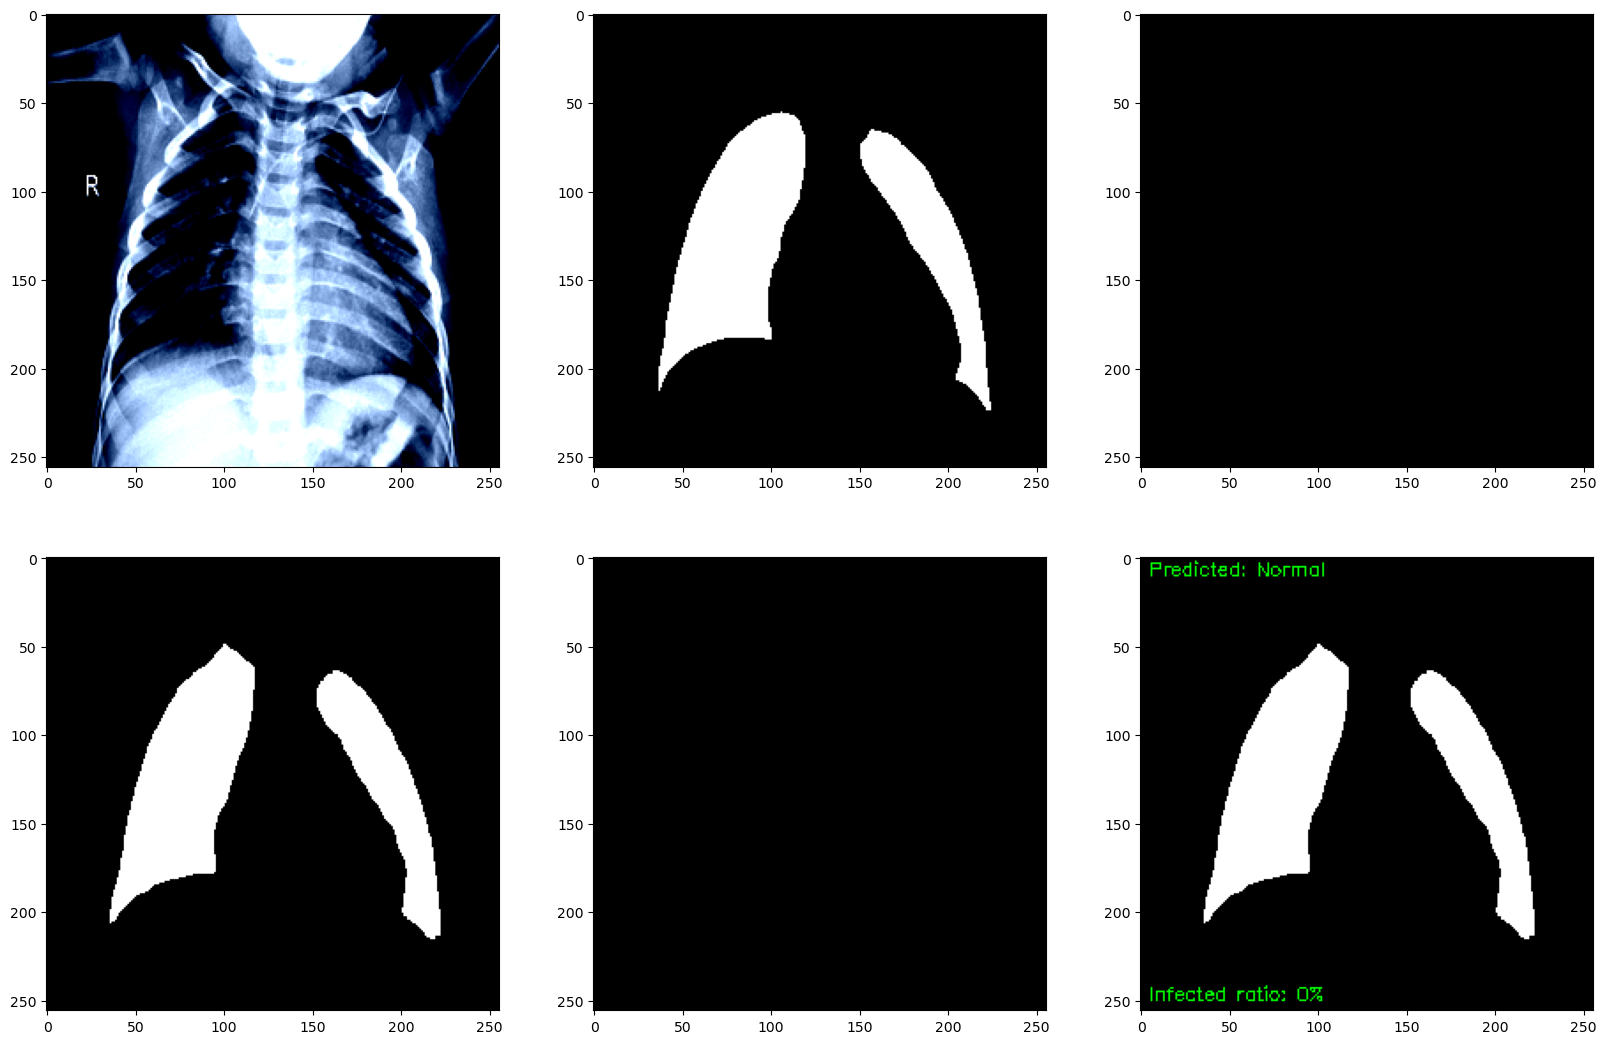

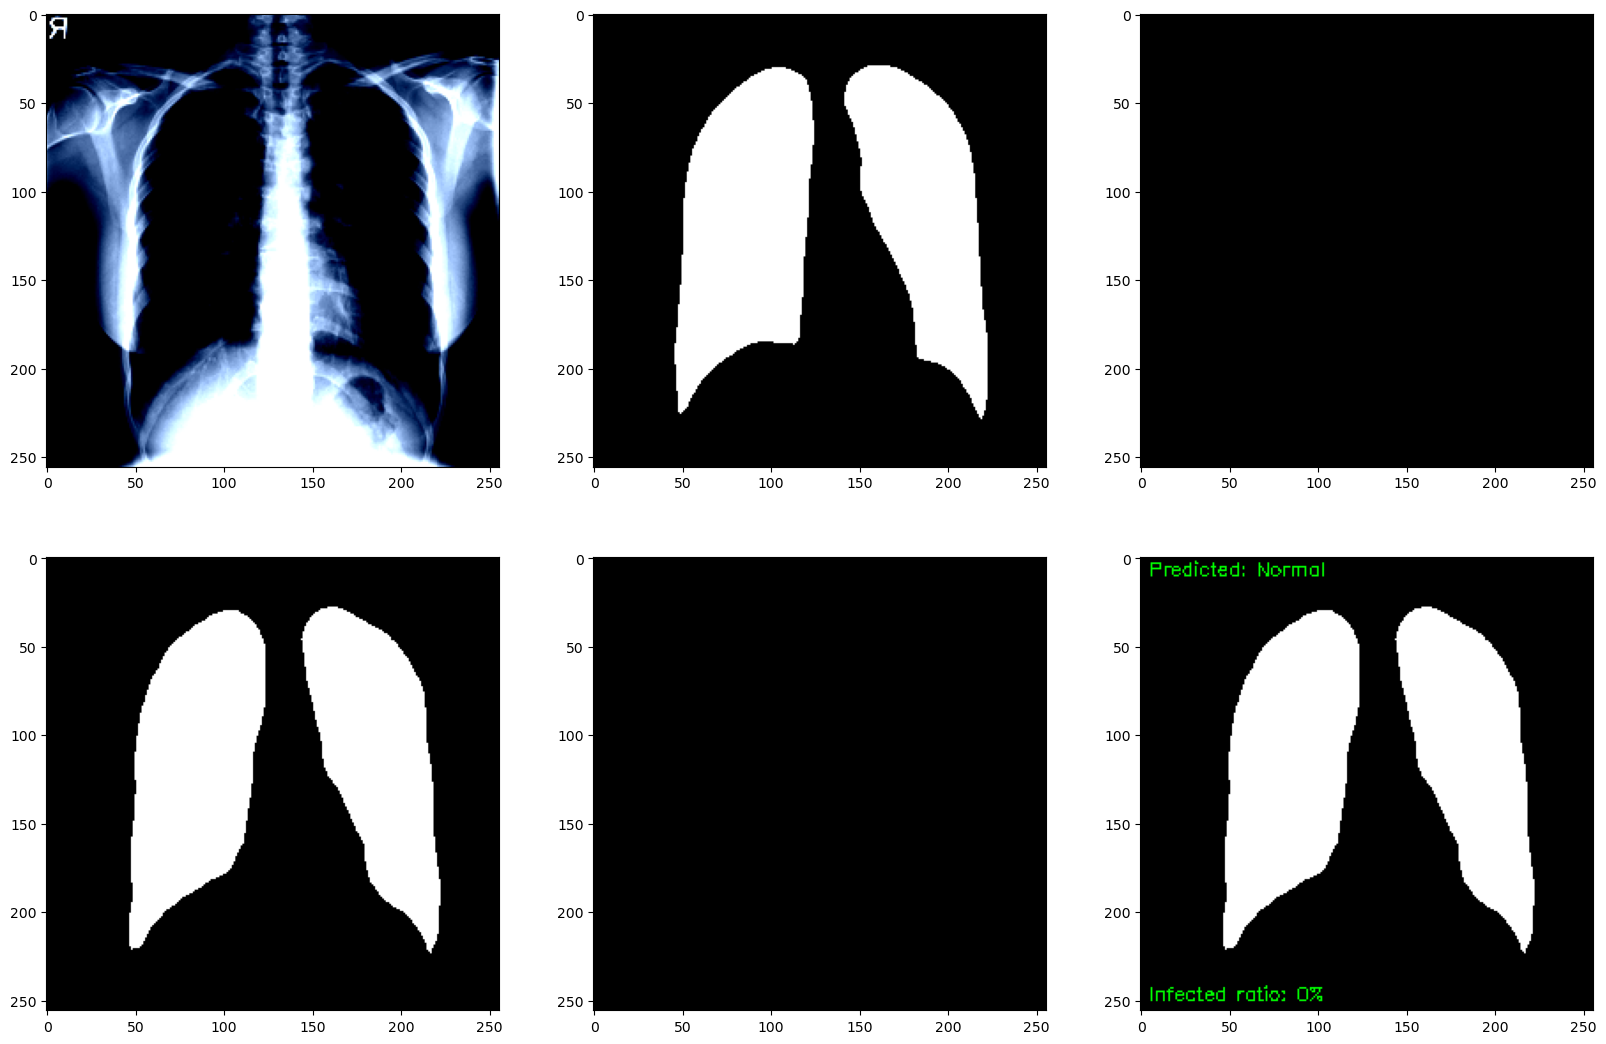

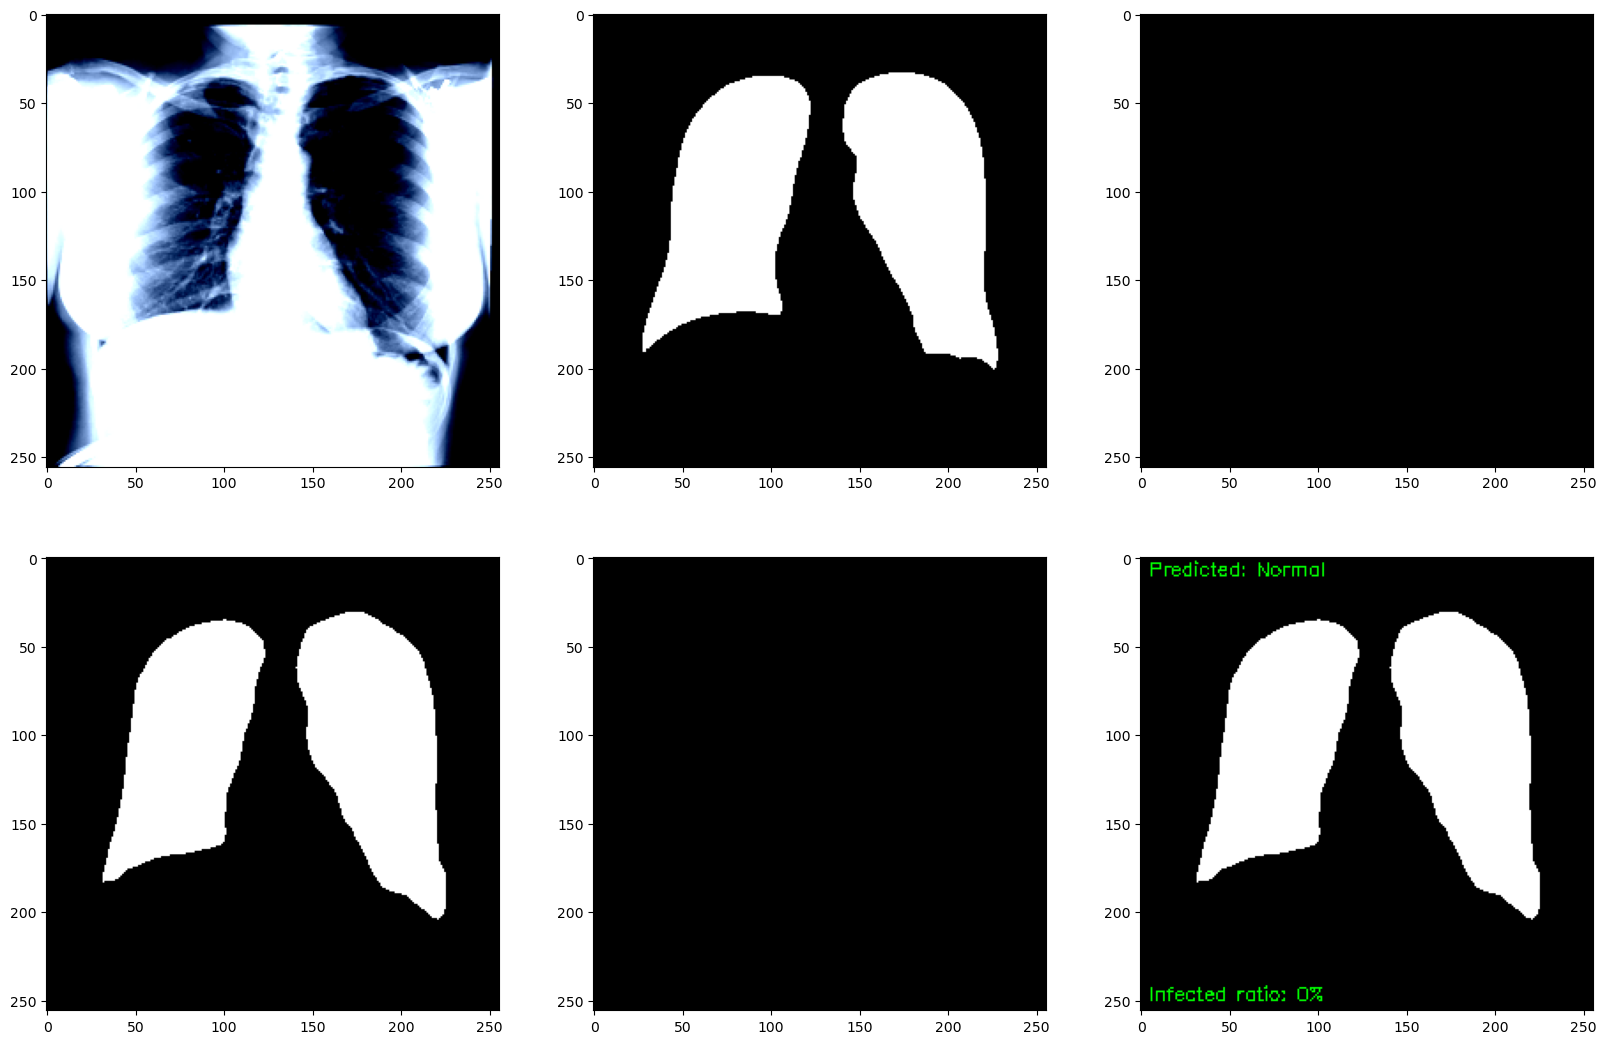

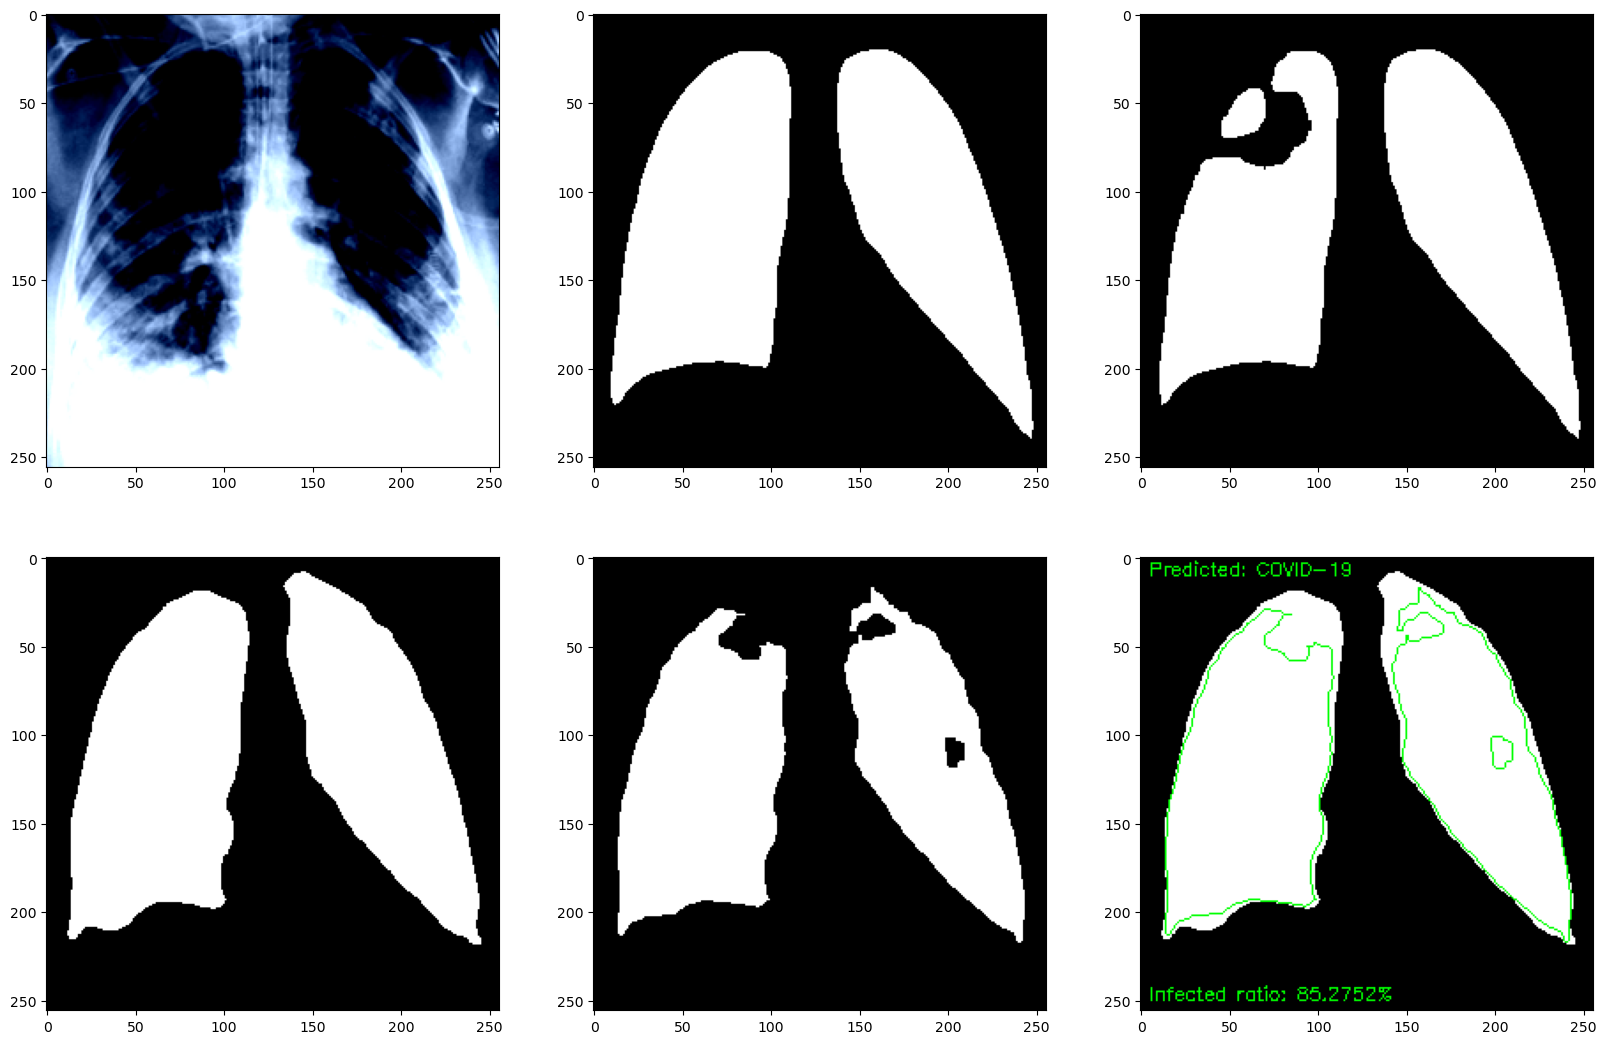

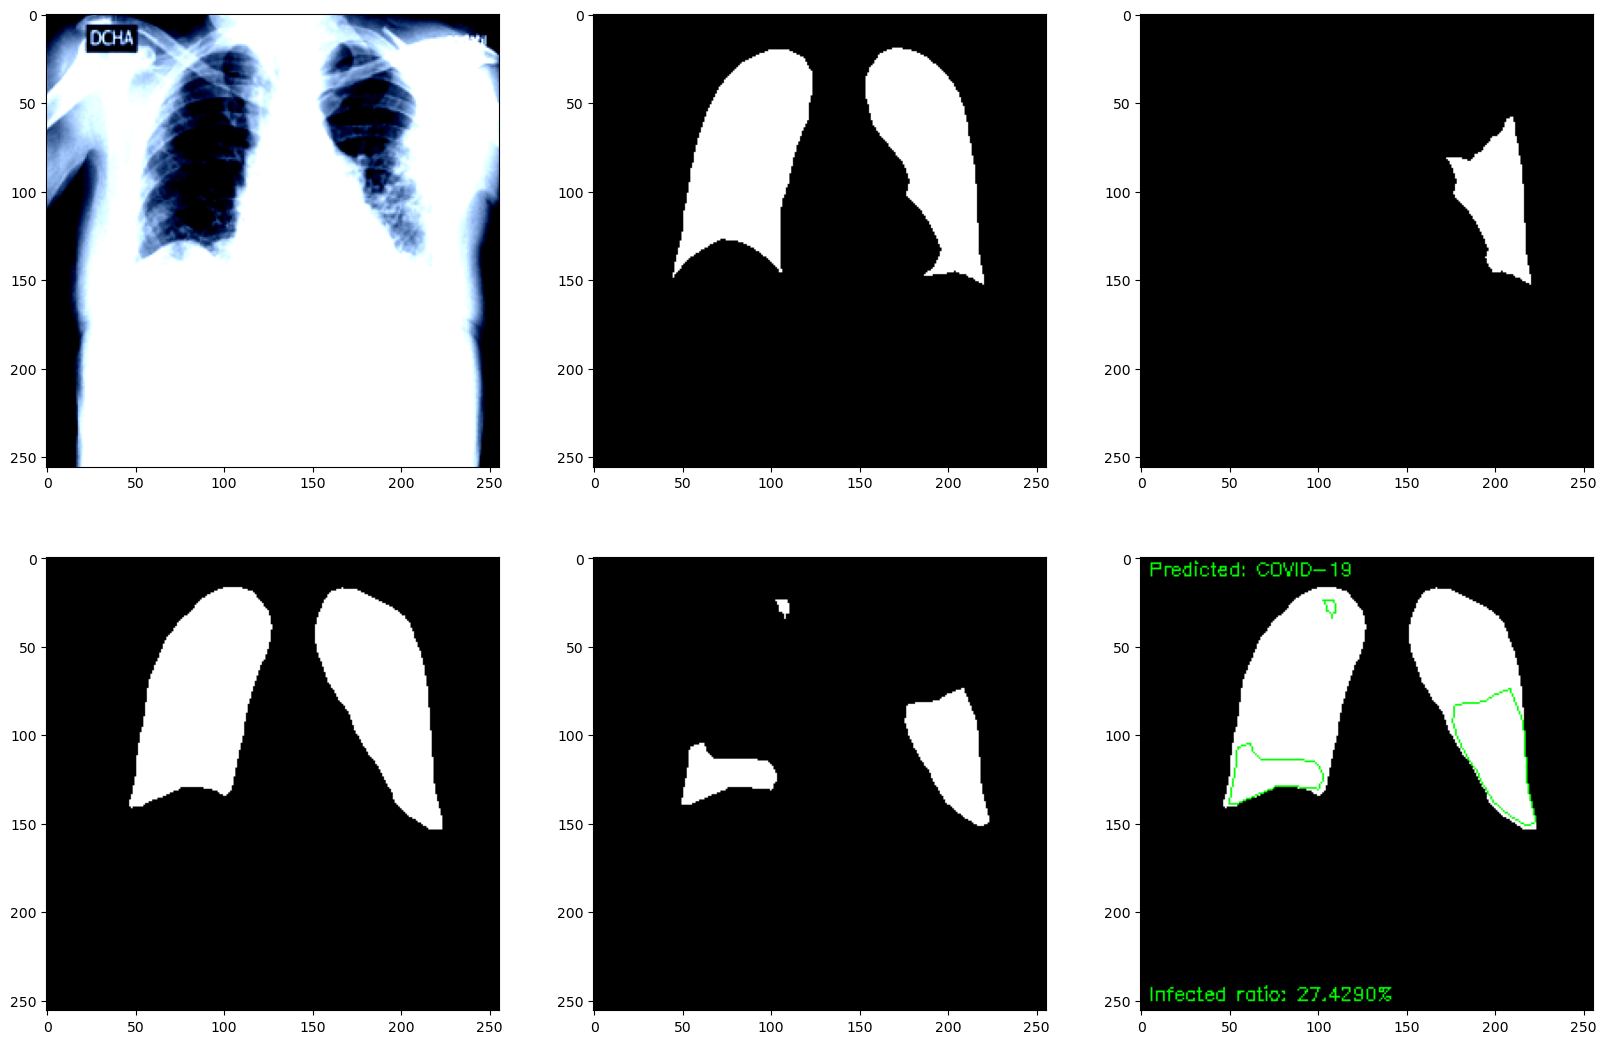

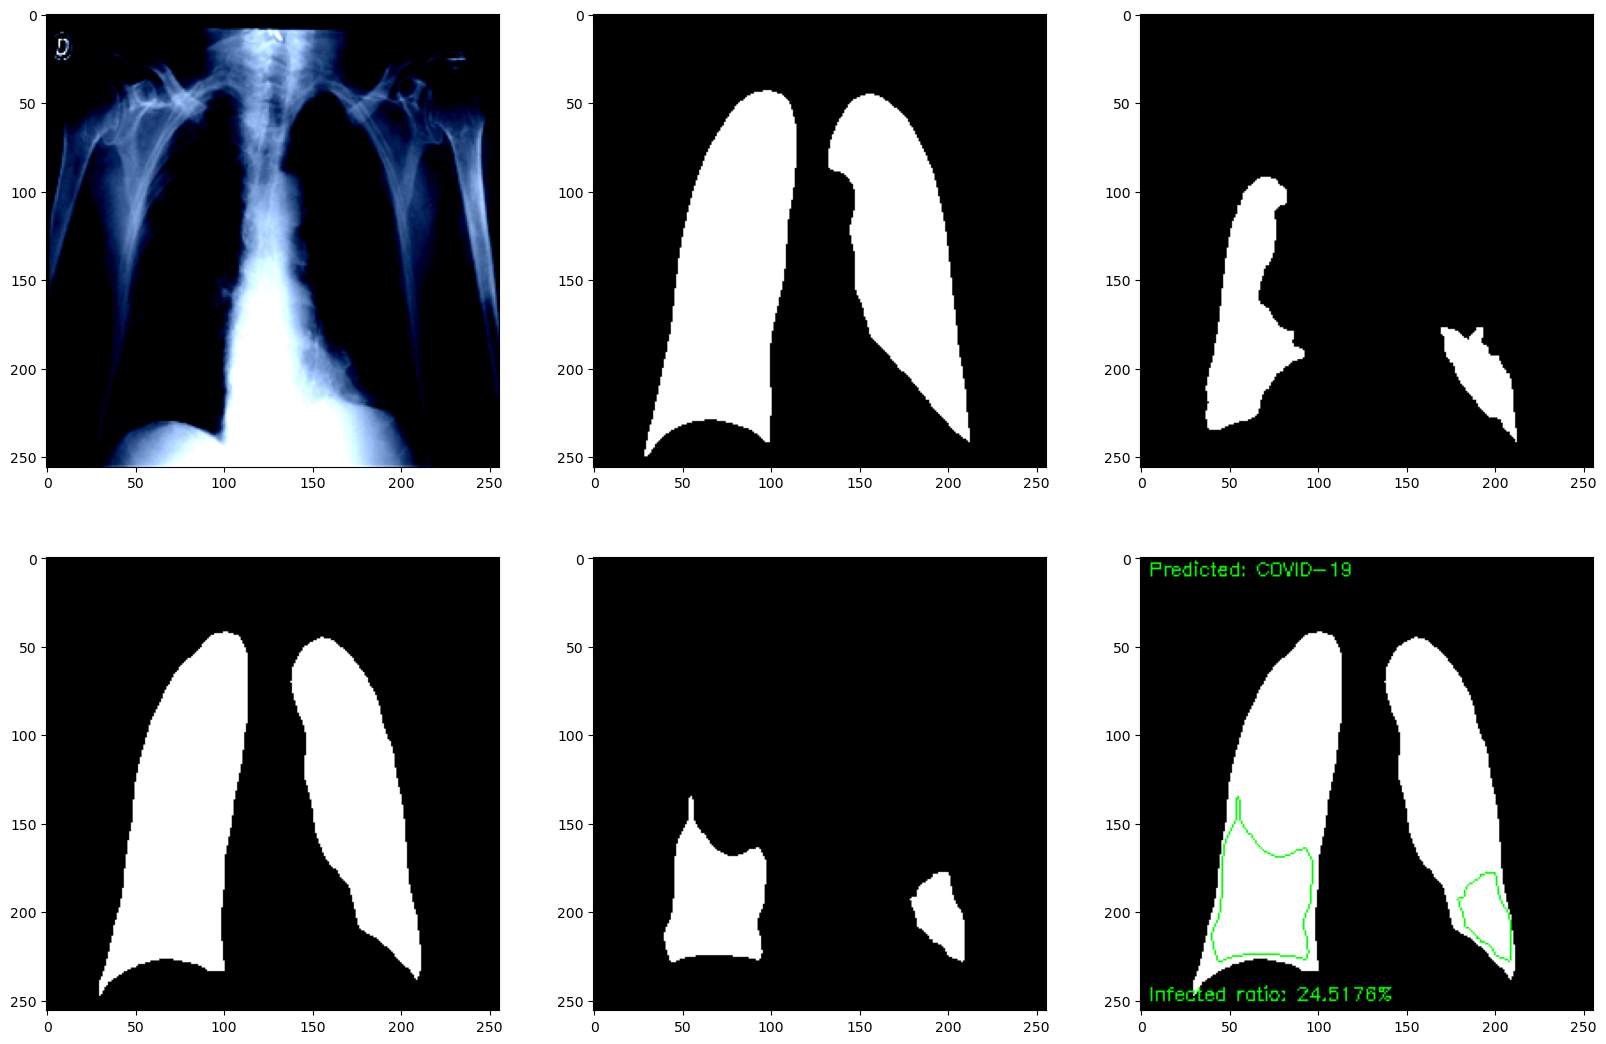

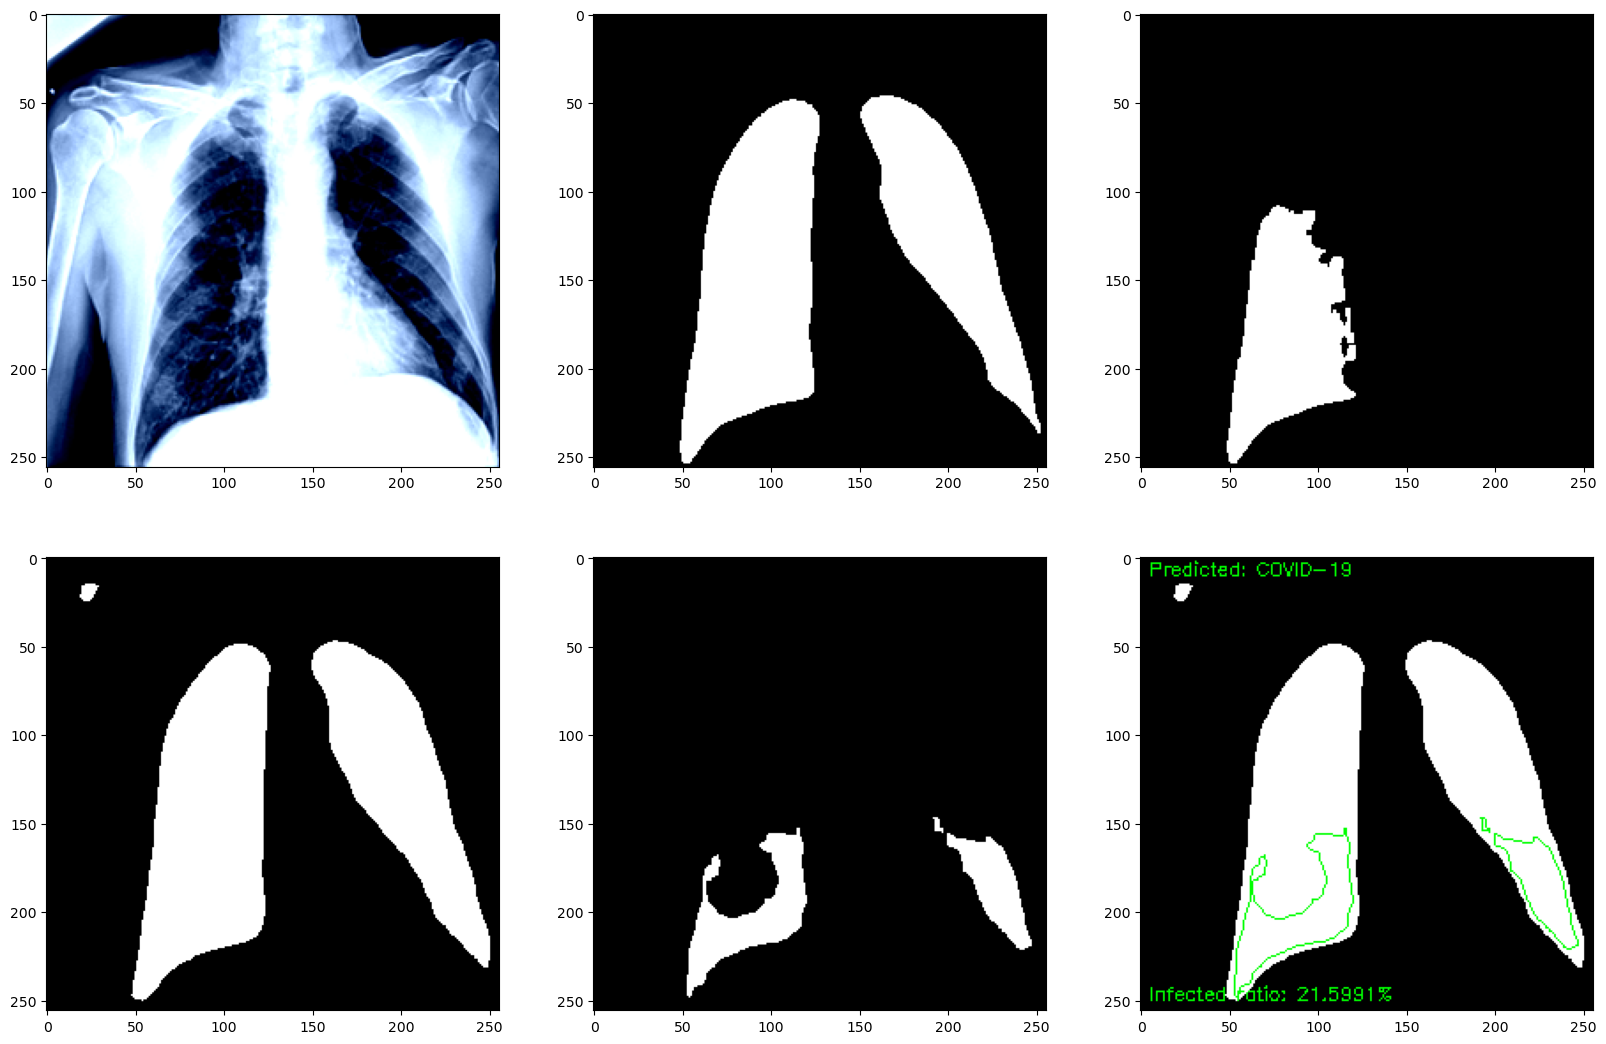

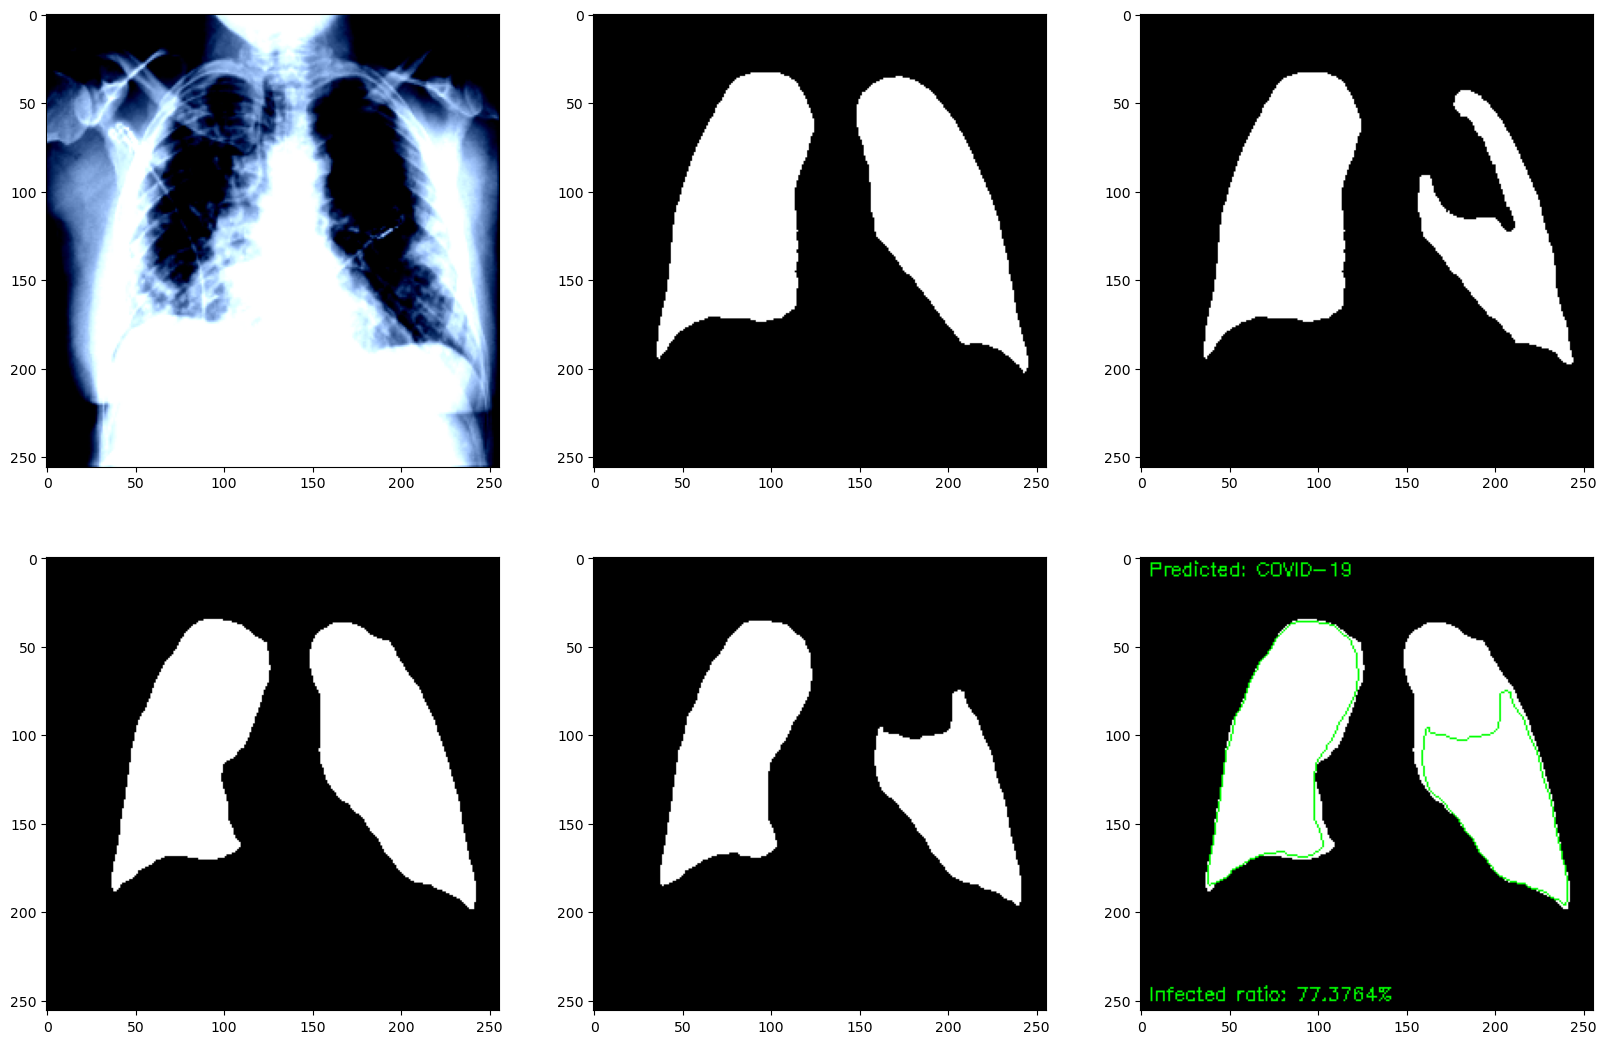

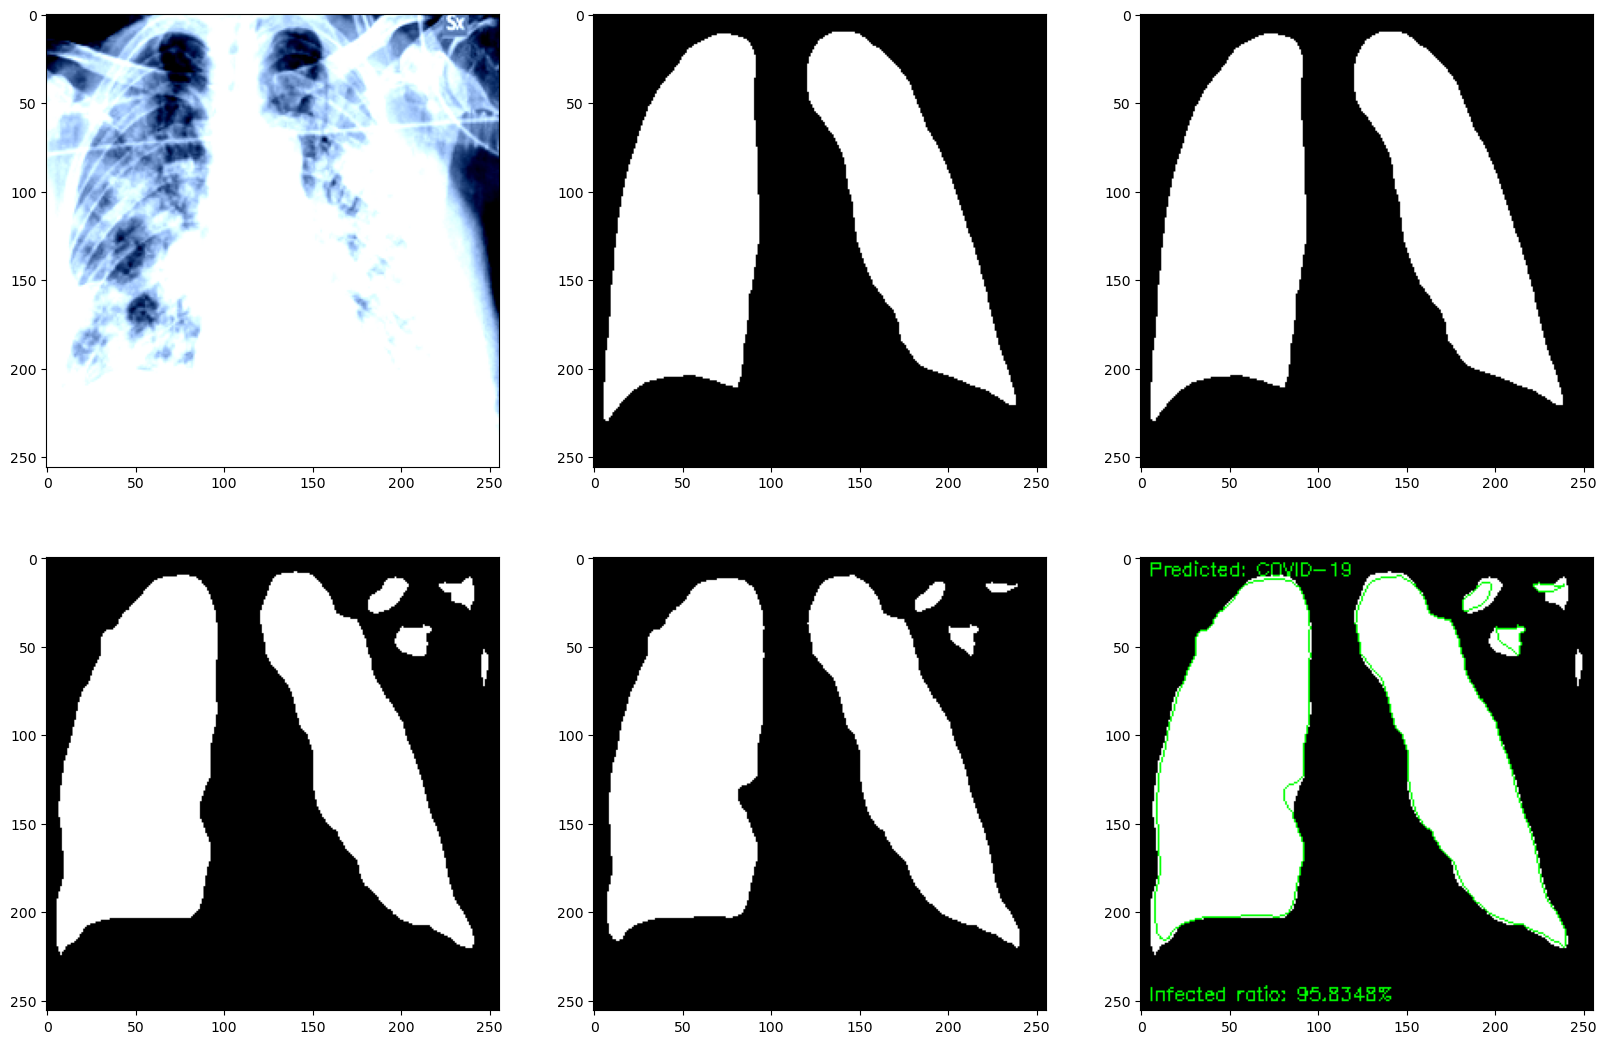

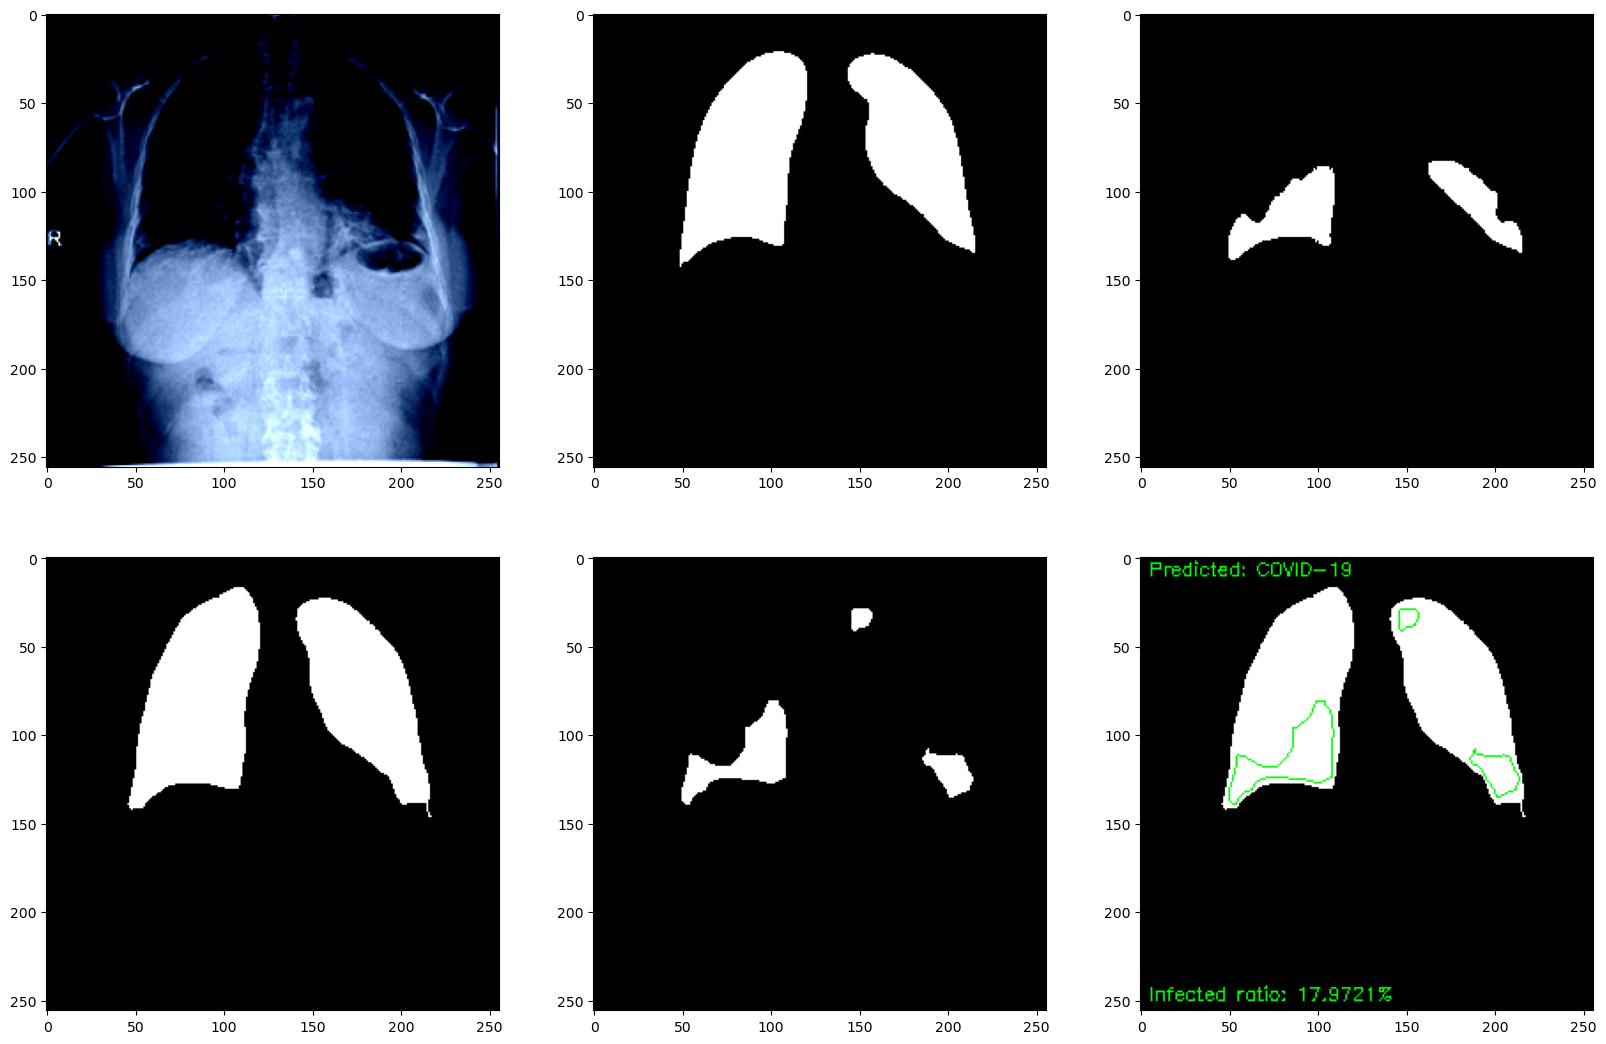

In [64]:
test_data = Covid('/kaggle/input/covidqu/Infection Segmentation Data/Infection Segmentation Data', mode='test' )
to_tensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

for i in range(580, 590):
    image, label_class, label_seg_lungs, label_seg_infected = test_data[i]
    
    fig = plt.figure(figsize=(20, 20))
    fig.add_subplot(3, 3, 1)
    plt.imshow(image.permute(1, 2, 0), cmap='gray')
    fig.add_subplot(3, 3, 2)
    plt.imshow(label_seg_lungs.argmax(0, keepdim=True).permute(1, 2, 0), cmap='gray')
    fig.add_subplot(3, 3, 3)
    plt.imshow(label_seg_infected.argmax(0, keepdim=True).permute(1, 2, 0), cmap='gray')
    
    image = image.unsqueeze(0).to('cpu').numpy()
    with torch.no_grad():
        output_class, output_seg_lungs, output_seg_infected = compiled_model_onnx(image).values()

    output_class = output_class.argmax(1)
    output_seg_lungs = (np.transpose(output_seg_lungs.argmax(1), (1, 2, 0))*255).astype('uint8')
    output_seg_infected = (np.transpose(output_seg_infected.argmax(1), (1, 2, 0))*255).astype('uint8')
      
    _, output_seg_lungs, output_seg_infected, infected_ratio, illustrate_im = post_processing(output_class, output_seg_lungs, output_seg_infected)
    
    fig.add_subplot(3, 3, 4)
    plt.imshow(output_seg_lungs,cmap='gray')
    fig.add_subplot(3, 3, 5)
    plt.imshow(output_seg_infected,cmap='gray')    
    fig.add_subplot(3, 3, 6)
    plt.imshow(illustrate_im,cmap='gray')